<a href="https://colab.research.google.com/github/HasanF19/YZM308_FINAL_PROJECT/blob/main/YZM308_Final_Atakan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hasan ***Atakan*** Öztürk 220212002

Üretken Yapay Zeka YZM308 Final Projesi Türkçe şarkı sözü Üretimi


#Proje Temeli GenAi kısmı

##1.Kurulum ve import

In [32]:
!pip install --quiet sentencepiece tensorflow pandas openpyxl


In [48]:

import pandas as pd, sentencepiece as spm, tensorflow as tf, numpy as np, os, io, textwrap
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


##2.Dataset Tanıtım

In [34]:
#Öncelikle sizlere datasetimi tanıtmak istiyorum csv formatındaki bu dosyanın düzenlenmiş hali kullanılmaktadır
# *yüklüyoruz*
data = pd.read_csv("/content/drive/MyDrive/Python/son_hali_artik.csv")
data.head()

,sarkici,sarkisi,album,sozler
0,Ahmet Kaya,"(Potbori) Fabrika Kızı, Cama Çıkma, Fabrika Önü",Şafak Türküsü,Bir mavi otobüs gelirdi\nSeni alır giderdi\nO ...
1,Ahmet Kaya,Acı Ninni,Baş Kaldırıyorum,"Uyusun ha iyi büyüsün,\nCamlar buğulanmasın\nS..."
2,Ahmet Kaya,Acılara Tutunmak,Acılara Tutunmak,Kavuşmak özgürlükse özgürdük ikimiz de\nElleri...
3,Ahmet Kaya,Ada Sahilleri,Hoşçakalın Gözüm,Ada sahillerinde bekliyorum\nHer zaman yolları...
4,Ahmet Kaya,Adı Bahtiyar,Dinle Sevgili Ülkem,"Geçiyor önümden, sirenler içinde\nAh eller üst..."


In [35]:
print("Şarkıcı listesi---->Şarkı sayısı:\n",data.sarkici.value_counts())
print("Dataset boyutu:",data.shape)

Şarkıcı listesi---->Şarkı sayısı:
 sarkici
Zeki Müren                 500
Müslüm Gürses              432
Sezen Aksu                 357
Sagopa Kajmer              321
Orhan Gencebay             295
Serdar Ortaç               243
Ahmet Kaya                 224
Ceza                       211
Barış Manço                157
Sertab Erener              156
Zülfü Livaneli             148
Cem Adrian                 140
Tarkan                     138
Candan Erçetin             137
Cem Karaca                 136
Kayahan                    124
Mustafa Sandal             120
Nazan Öncel                120
Feridun Düzağaç            107
Yaşar                      106
Mazhar Fuat Özkan (MFÖ)     99
Şebnem Ferah                97
Mor Ve Ötesi                97
Yeni Türkü                  95
Teoman                      85
Duman                       84
Mabel Matiz                 72
Pinhani                     68
Can Bonomo                  60
Ezhel                       23
Büyük Ev Ablukada          

##3.Dosya okuma ve epoch seçimi temel gövde
*###Seçilen epochlar 9.Aşamada kullanılacak*

In [41]:
EXCEL_FILE  = "/content/drive/MyDrive/Python/turkish.xlsx"     # yüklediğiniz dosya adı
TEXT_COLUMN = "lyrics"# sözlerin bulunduğu sütun
MODEL_PREFIX = "tr_lyric" # tokenizer dosya adı
VOCAB_SIZE   = 16000# BPE sözlük boyutu
SEQ_LEN      = 256# giriş uzunluğu (token)
EMBED_DIM    = 256
LSTM_UNITS   = 1024
BATCH_SIZE   = 128
EPOCHS       = 20
#3 epoch ile başladık A100 ile ort 10dk model.fit 9.aşamada
#20 epoch batchi de 128 yaptık ortalama 20dk sürecek
#SEQ_LEN= 256 EMBED_DIM= 512 LSTM_UNITS=1024 BATCH_SIZE=128 40 EPOCHS KOD PATLADI







In [42]:
es = EarlyStopping(
    monitor='loss',           # 'val_loss' yerine 'loss'
    patience=5,               # kaç epoch sabredeceği
    restore_best_weights=True # en düşük eğitim kaybını geri yükle
)

##4.Veri işleme adım 1 txt çevirme
*### excel işleri karıştırdı veriyi işlemek için txt çektik (sonradan öğrendim utf-8 hatasıymış)*


In [43]:
df = pd.read_excel(EXCEL_FILE)
lines = df[TEXT_COLUMN].dropna().astype(str).tolist()

with open("corpus.txt", "w", encoding="utf-8") as f:
    for l in lines:
        # her satırı tek bir örnek; varsa satır sonlarında aşağı inecek(olmadı)
        f.write(l.replace("\r", "") + "\n")


##5.Tokenizer İşlemleri
*###Excel iptal*

In [44]:
if not os.path.exists(f"{MODEL_PREFIX}.model"):
    spm.SentencePieceTrainer.train(
        input="corpus.txt",
        model_prefix=MODEL_PREFIX,
        vocab_size=VOCAB_SIZE,
        model_type="bpe",
        character_coverage=1.0,
        pad_id=0, unk_id=1, bos_id=-1, eos_id=2
    )

sp = spm.SentencePieceProcessor(model_file=f"{MODEL_PREFIX}.model")
vocab_size = sp.get_piece_size()


##6.Modelde kullanmak iççin veriyi diziye dönüştürüyoruz

In [45]:
def encode(sentence):
    return sp.encode(sentence.strip(), out_type=int) + [sp.eos_id()]

sequences = [encode(l) for l in lines if l.strip()]

x_data, y_data = [], []
for seq in sequences:
    for i in range(1, len(seq)):
        chunk = seq[max(0, i-SEQ_LEN):i+1]
        x_data.append(chunk[:-1])
        y_data.append(chunk[-1])

x_data = tf.keras.preprocessing.sequence.pad_sequences(
    x_data, maxlen=SEQ_LEN, padding="pre")
y_data = np.array(y_data)

dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
dataset = dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)


##7.Model kurulumu Aktivasyon fonk. Softmax ve Learning rate

In [46]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, EMBED_DIM, input_length=SEQ_LEN),
    tf.keras.layers.LSTM(LSTM_UNITS),
    tf.keras.layers.Dense(vocab_size, activation="softmax")
])

optimizer = Adam(learning_rate=0.005)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy"
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


##8.Model fit :)

In [49]:
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/MRT_SMSK/best_model.keras',
    monitor='loss',
    save_best_only=True
)#loss yükselmeye başlarsa son epochu kaydedecek

history = model.fit(
    dataset,
    epochs=EPOCHS,
    callbacks=[es,  checkpoint]
)

Epoch 1/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 193s 31ms/step - loss: 8.7677
Epoch 2/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 31ms/step - loss: 7.0092
Epoch 3/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 31ms/step - loss: 5.9601
Epoch 4/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 189s 31ms/step - loss: 5.1801
Epoch 5/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 189s 31ms/step - loss: 4.9025
Epoch 6/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 31ms/step - loss: 4.7771
Epoch 7/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 31ms/step - loss: 4.5569
Epoch 8/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 31ms/step - loss: 4.3636
Epoch 9/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 30ms/step - loss: 4.2262
Epoch 10/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 30ms/step - loss: 4.1187
Epoch 11/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 30ms/step - loss: 4.0542
Epoch 12/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 30ms/step - loss: 4.0299
Epoch 13/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 30ms/step - loss: 3.9915
Epoch 14/20
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 188s 30ms/step - 

In [51]:
history_df = pd.DataFrame(history.history)

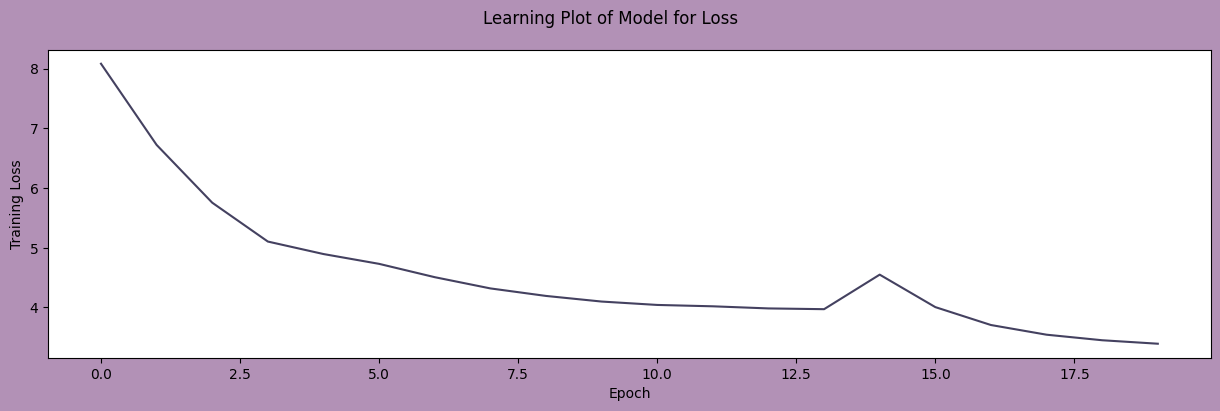

In [52]:
fig = plt.figure(figsize=(15,4), facecolor="#B291B6")
fig.suptitle("Learning Plot of Model for Loss")
pl = sns.lineplot(data=history_df["loss"], color="#444160")
pl.set(ylabel="Training Loss", xlabel="Epoch")
plt.show()

##9 Örnekleme Aşaması (NUCLEUS (TOP-p)) kullanıldı.

In [53]:
def sample_top_p(preds, temperature=0.8, top_p=0.9):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-8) / temperature
    probs = np.exp(preds)
    probs = probs / np.sum(probs)
    sorted_idx = np.argsort(probs)[::-1]
    cumulative = np.cumsum(probs[sorted_idx])
    keep = cumulative <= top_p
    idxs = sorted_idx[keep]
    if len(idxs) == 0:
        idxs = sorted_idx[:1]
    probs = probs[idxs] / probs[idxs].sum()
    return np.random.choice(idxs, p=probs)

def generate(seed_text, max_tokens=120, temperature=0.8, top_p=0.9):
    ids = sp.encode(seed_text, out_type=int)
    for _ in range(max_tokens):
        padded = tf.keras.preprocessing.sequence.pad_sequences(
            [ids], maxlen=SEQ_LEN, padding="pre")
        preds = model.predict(padded, verbose=0)[0]
        next_id = sample_top_p(preds, temperature, top_p)
        if next_id == sp.eos_id():
            break
        ids.append(int(next_id))
    return sp.decode(ids)


##9.Örnek üretimi **Proje GenAi kısmı sonu**
*### Resim üstü yazı olması için ve sonrasında arayüz için devam->17.04.2025*

In [65]:
print("---- ÖRNEK ÇIKIŞ ----")
print(generate("sevdik sevdalandık", max_tokens=120, temperature=0.5, top_p=0.95))
#Başlangıç parametrelerimiz çıktı kalitesi idare eder max_tokens=120, temperature=0.8, top_p=0.9))

---- ÖRNEK ÇIKIŞ ----
sevdik sevdalandık Bir kez kaybetip Söndü derler Aşkı bekleme Giden böyle insafsız böyle unutulsam maziden sardun canıma sarkantu kaybolanyalarince sessiz Geceyi çoktan unuttum kendimi Sende gördün diye Beklerim yolunu aylar boyunca korumak var aldırma


#Proje geliştirmeleri
####Bundan sonraki aşamalar çıktı kalitesi için ve makinenin daha iyi çalışması için olacaktır. Planlanan işler aşağıda belirtilmiştir. v1 Geliştirmeleri 20.01.2025 tarihinden önce yapılacaktır.

###Ekstra işler proje geliştirme

v1.1 (18.05.2025)
*   Drive üzerinde eğitilmiş model kaydı
*   Sözleri satır satır yazdırma,
*   Resim üzerine yazdırma

v2.0(After 22.05.2025)
*   Streamlit Arayüz tasarımı

V3.0 (Summer)
* yazdırılan sözlere uygun resim üretimi *textoimage*
    



##Model Kaydı

*Model kaydı deneme*

In [55]:
model.save('/content/drive/MyDrive/MRT_SMSK/20epoch.keras')

In [56]:
# ###Tekrar Kullanmak için Modeli Yükle

# from tensorflow.keras.models import load_model
# model = load_model('/content/drive/MyDrive/MRT_SMSK/my_model.keras')


*Eğitim sırasında checkpoint kaydetme varmış denenecek*

In [57]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint = ModelCheckpoint'/content/drive/MyDrive/MRT_SMSK/my_model.keras', save_best_only=True, monitor='loss', mode='min')
# model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint])


##Şarkı sözlerini satır satır ayırmak

In [58]:
def teksatirdeneme(lyrics):
    for line in lyrics.split('\n'):
        print(line)

In [71]:
#yukarıda oluşturduğumuz generate'i çağıracağım
print(teksatirdeneme(generate("sevdamızın adı", max_tokens=120, temperature=0.5, top_p=0.95)))
#olmadı satırın bittiğini anlamıyor virgüllerden böleceğim.

sevdamızın adı bir dua kondurur hayat Bizi yakma Kalbim var benim kaderim olsun Yıkıldım ben uslanmadım doymadım ben seni ben istiyorum
None


In [60]:
#virgülden bölme fonksiyonu
def virguldenbol(text):
    return text.replace(',', ',\n')


In [73]:
virguldenbol(generate("Allahım güç ver bana,seviyorum", max_tokens=120, temperature=0.5, top_p=0.9))
#bu niye çalışmadı ben de anlamaıdm--->yeni total fonksiyon tanımlanacak karışma ihtimaline karşı gener*

'Allahım güç ver bana,\nseviyorum,\n tutunacak Kimse bilmez,\n nice canını yaktım Bugün kendimi parkta Yok olmaz,\n beni,\n birileri var Duygularım,\n şimdi çığlık çığmana gerçekler,\n serzen bilir,\n büyüyo Sonra söyledim İşte kuzu kuzu Yanılmış açan dalı,\n yalan,\n yalan söylemezler Kalemim şahit benim değil,\n Sormayın,\n önce sığınamıyorum dünyaya Bütün gözlerim'

In [62]:
def vırgul(text):
    """
    Metindeki her virgülden sonra alt satıra geçmek için '\\n' ekler.
    """
    return text.replace(',', ',\n')

def gener(seed_text, max_tokens=120, temperature=0.8, top_p=0.9):
    ids = sp.encode(seed_text, out_type=int)
    for _ in range(max_tokens):
        padded = tf.keras.preprocessing.sequence.pad_sequences(
            [ids], maxlen=SEQ_LEN, padding="pre")
        preds = model.predict(padded, verbose=0)[0]
        next_id = sample_top_p(preds, temperature, top_p)
        if next_id == sp.eos_id():
            break
        ids.append(int(next_id))

    generated_text = sp.decode(ids)
    formatted_text = vırgul(generated_text)
    return formatted_text

In [64]:
print((gener("sevdik sevdalandık", max_tokens=120, temperature=0.5, top_p=0.9)))
#Satır ayırmanın virgüllere bağlandığında bazı çıktılarda çalışmadığını sonradan öğrendim resim sonrası tekrardan uğraşacağım

sevdik sevdalandık Bir kez haykırsam belki bir daha geri gelmiyorsun sen Seni sevmeyi sevmiyorum Acımı bu kadar anlamazken Bir rüzgar Savur savrul Günaydın Yalnız benim olacak Belki daha uykunuz da öyle geliyor Benim hala yanıyor yine de kitapta oldu Küçük bir hatıra var Memleket aşkının bısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyIısıyI


##Resim üstüne yazı ile şiir paylaşım konsepti

---



In [76]:
from PIL import Image, ImageDraw, ImageFont

# 1⃣ Görsel dosyalarının yollarını değişkene ata
image_path  = "/content/drive/MyDrive/Python/acikfon.jpg"
output_path = "/content/drive/MyDrive/MRT_SMSK/cikti.jpg"

# 2⃣ Görsel üzerine yazı basan fonksiyon
def resim_ustune(image_path, lyrics, output_path):
    image = Image.open(image_path)
    draw  = ImageDraw.Draw(image)
    font = ImageFont.truetype("/content/drive/MyDrive/Python/times.ttf", 100)
    text_position = (120, 120)
    draw.multiline_text(text_position, lyrics, font=font, fill="black")
    image.save(output_path)
    image.show()

# 3⃣ Şarkı sözü üret
lyrics = gener(
    "Sensiz geçen günler",
    max_tokens=300,
    temperature=0.6,
    top_p=0.9
)
# 4⃣ Fonksiyonu çağır
resim_ustune(image_path, lyrics, output_path)


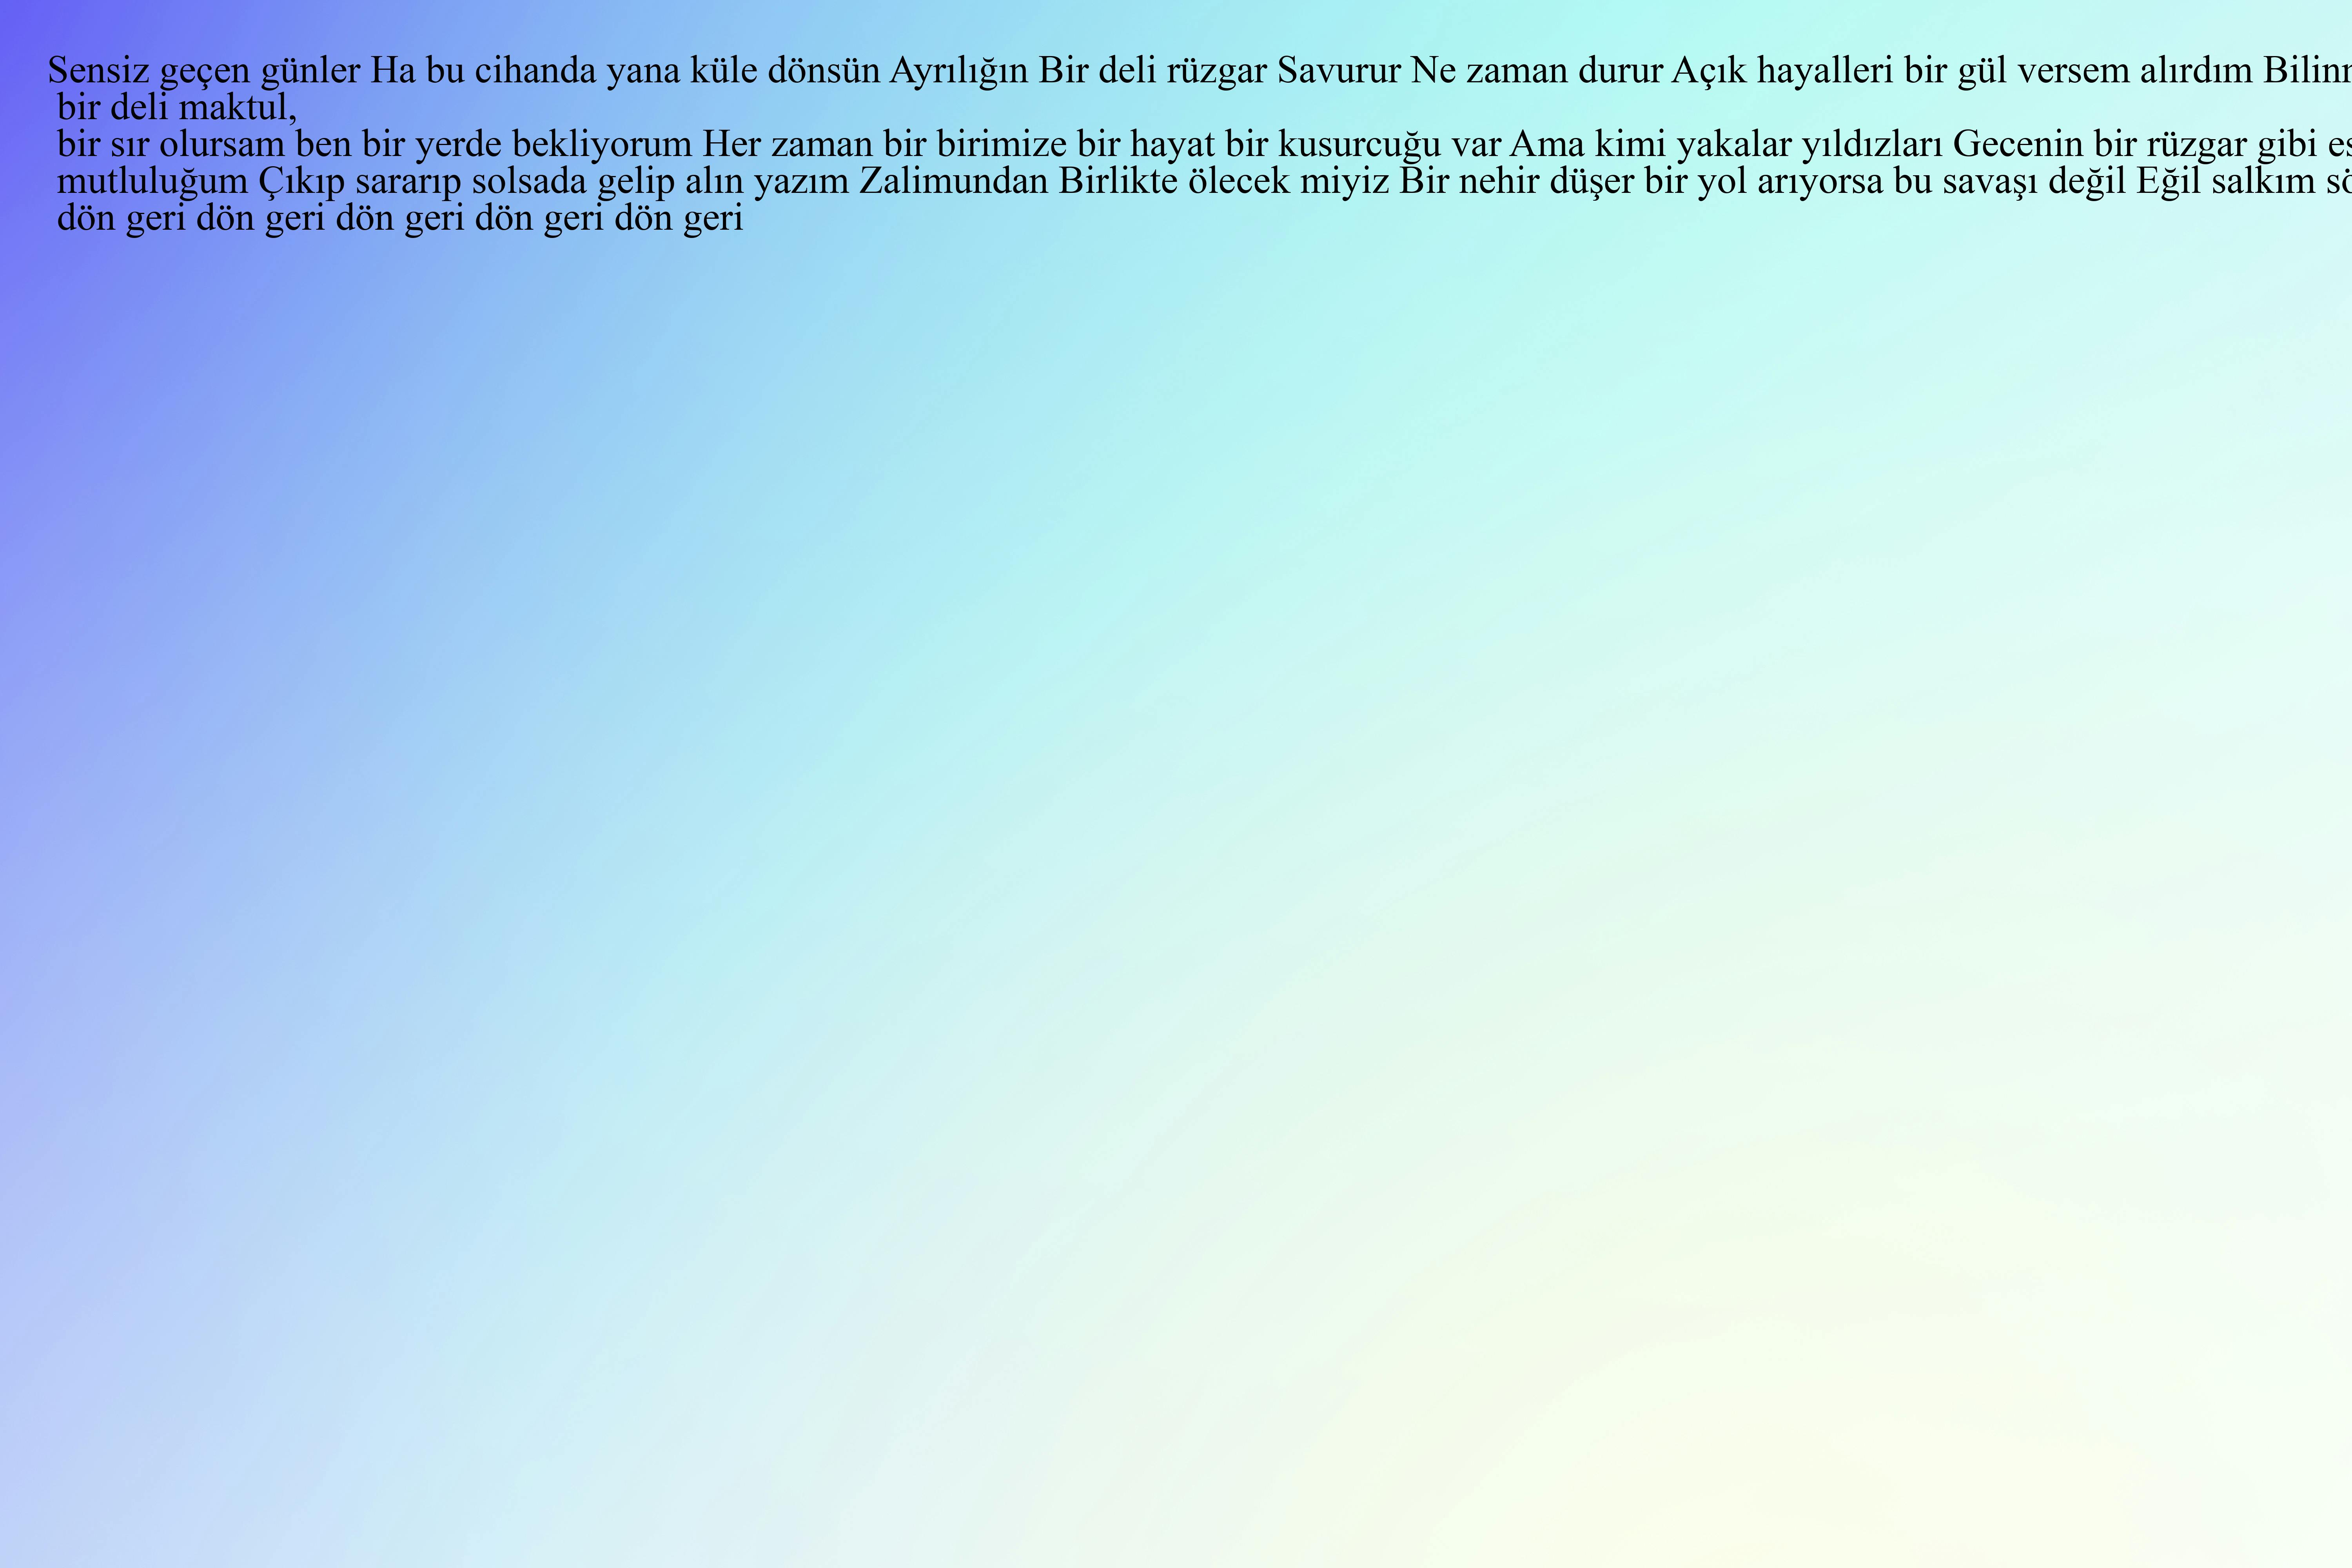

In [77]:
from IPython.display import Image as ColabImage, display
display(ColabImage(output_path))


##Satır Ayırma Kaliteli olacak
####virgülden ayırma bazı çıktılarda özellikle temp<0.5 ise çok
 bozuyor
####cümle başlangıçlarını büyük harflerle tespit edip böleceğimn
####fonksiyon generative-->gener-->yener

In [68]:
import re
def buyukharf(text):
    text = re.sub(r'(?<!\n)([A-ZÇĞİÖŞÜ])', r'\n\1', text)
    return text
def yener(seed_text, max_tokens=120, temperature=0.8, top_p=0.9):
    ids = sp.encode(seed_text, out_type=int)
    for _ in range(max_tokens):
        padded = tf.keras.preprocessing.sequence.pad_sequences(
            [ids], maxlen=SEQ_LEN, padding="pre")
        preds = model.predict(padded, verbose=0)[0]
        next_id = sample_top_p(preds, temperature, top_p)
        if next_id == sp.eos_id():
            break
        ids.append(int(next_id))

    generated_text = sp.decode(ids)
    formatted_text = buyukharf(generated_text)
    return formatted_text

In [69]:
print((yener("seni özledim", max_tokens=100, temperature=0.6, top_p=0.9)))

seni özledim bir kere 
Cehennem dertleri var cennetimde 
Ne oldu başıma ne özeldizayı kedim 
Ben gözümü bilmezler 
Ben şarkımı söylerken ey


In [102]:
from PIL import Image, ImageDraw, ImageFont

# 1⃣ Görsel dosyalarının yollarını değişkene ata
image_path  = "/content/drive/MyDrive/Python/acikfon.jpg"
output_path = "/content/drive/MyDrive/MRT_SMSK/cikti.jpg"

# 2⃣ Görsel üzerine yazı basan fonksiyon
def resim_ustune(image_path, lyrics, output_path):
    image = Image.open(image_path)
    draw  = ImageDraw.Draw(image)
    font = ImageFont.truetype("/content/drive/MyDrive/Python/times.ttf", 100)
    text_position = (120, 120)
    draw.multiline_text(text_position, lyrics, font=font, fill="black")
    image.save(output_path)
    image.show()

# 3⃣ Şarkı sözü üret
lyrics = yener(
    "Nerde mutluluk?",
    max_tokens=1000,
    temperature=0.6,
    top_p=0.9
)
# 4⃣ Fonksiyonu çağır
resim_ustune(image_path, lyrics, output_path)

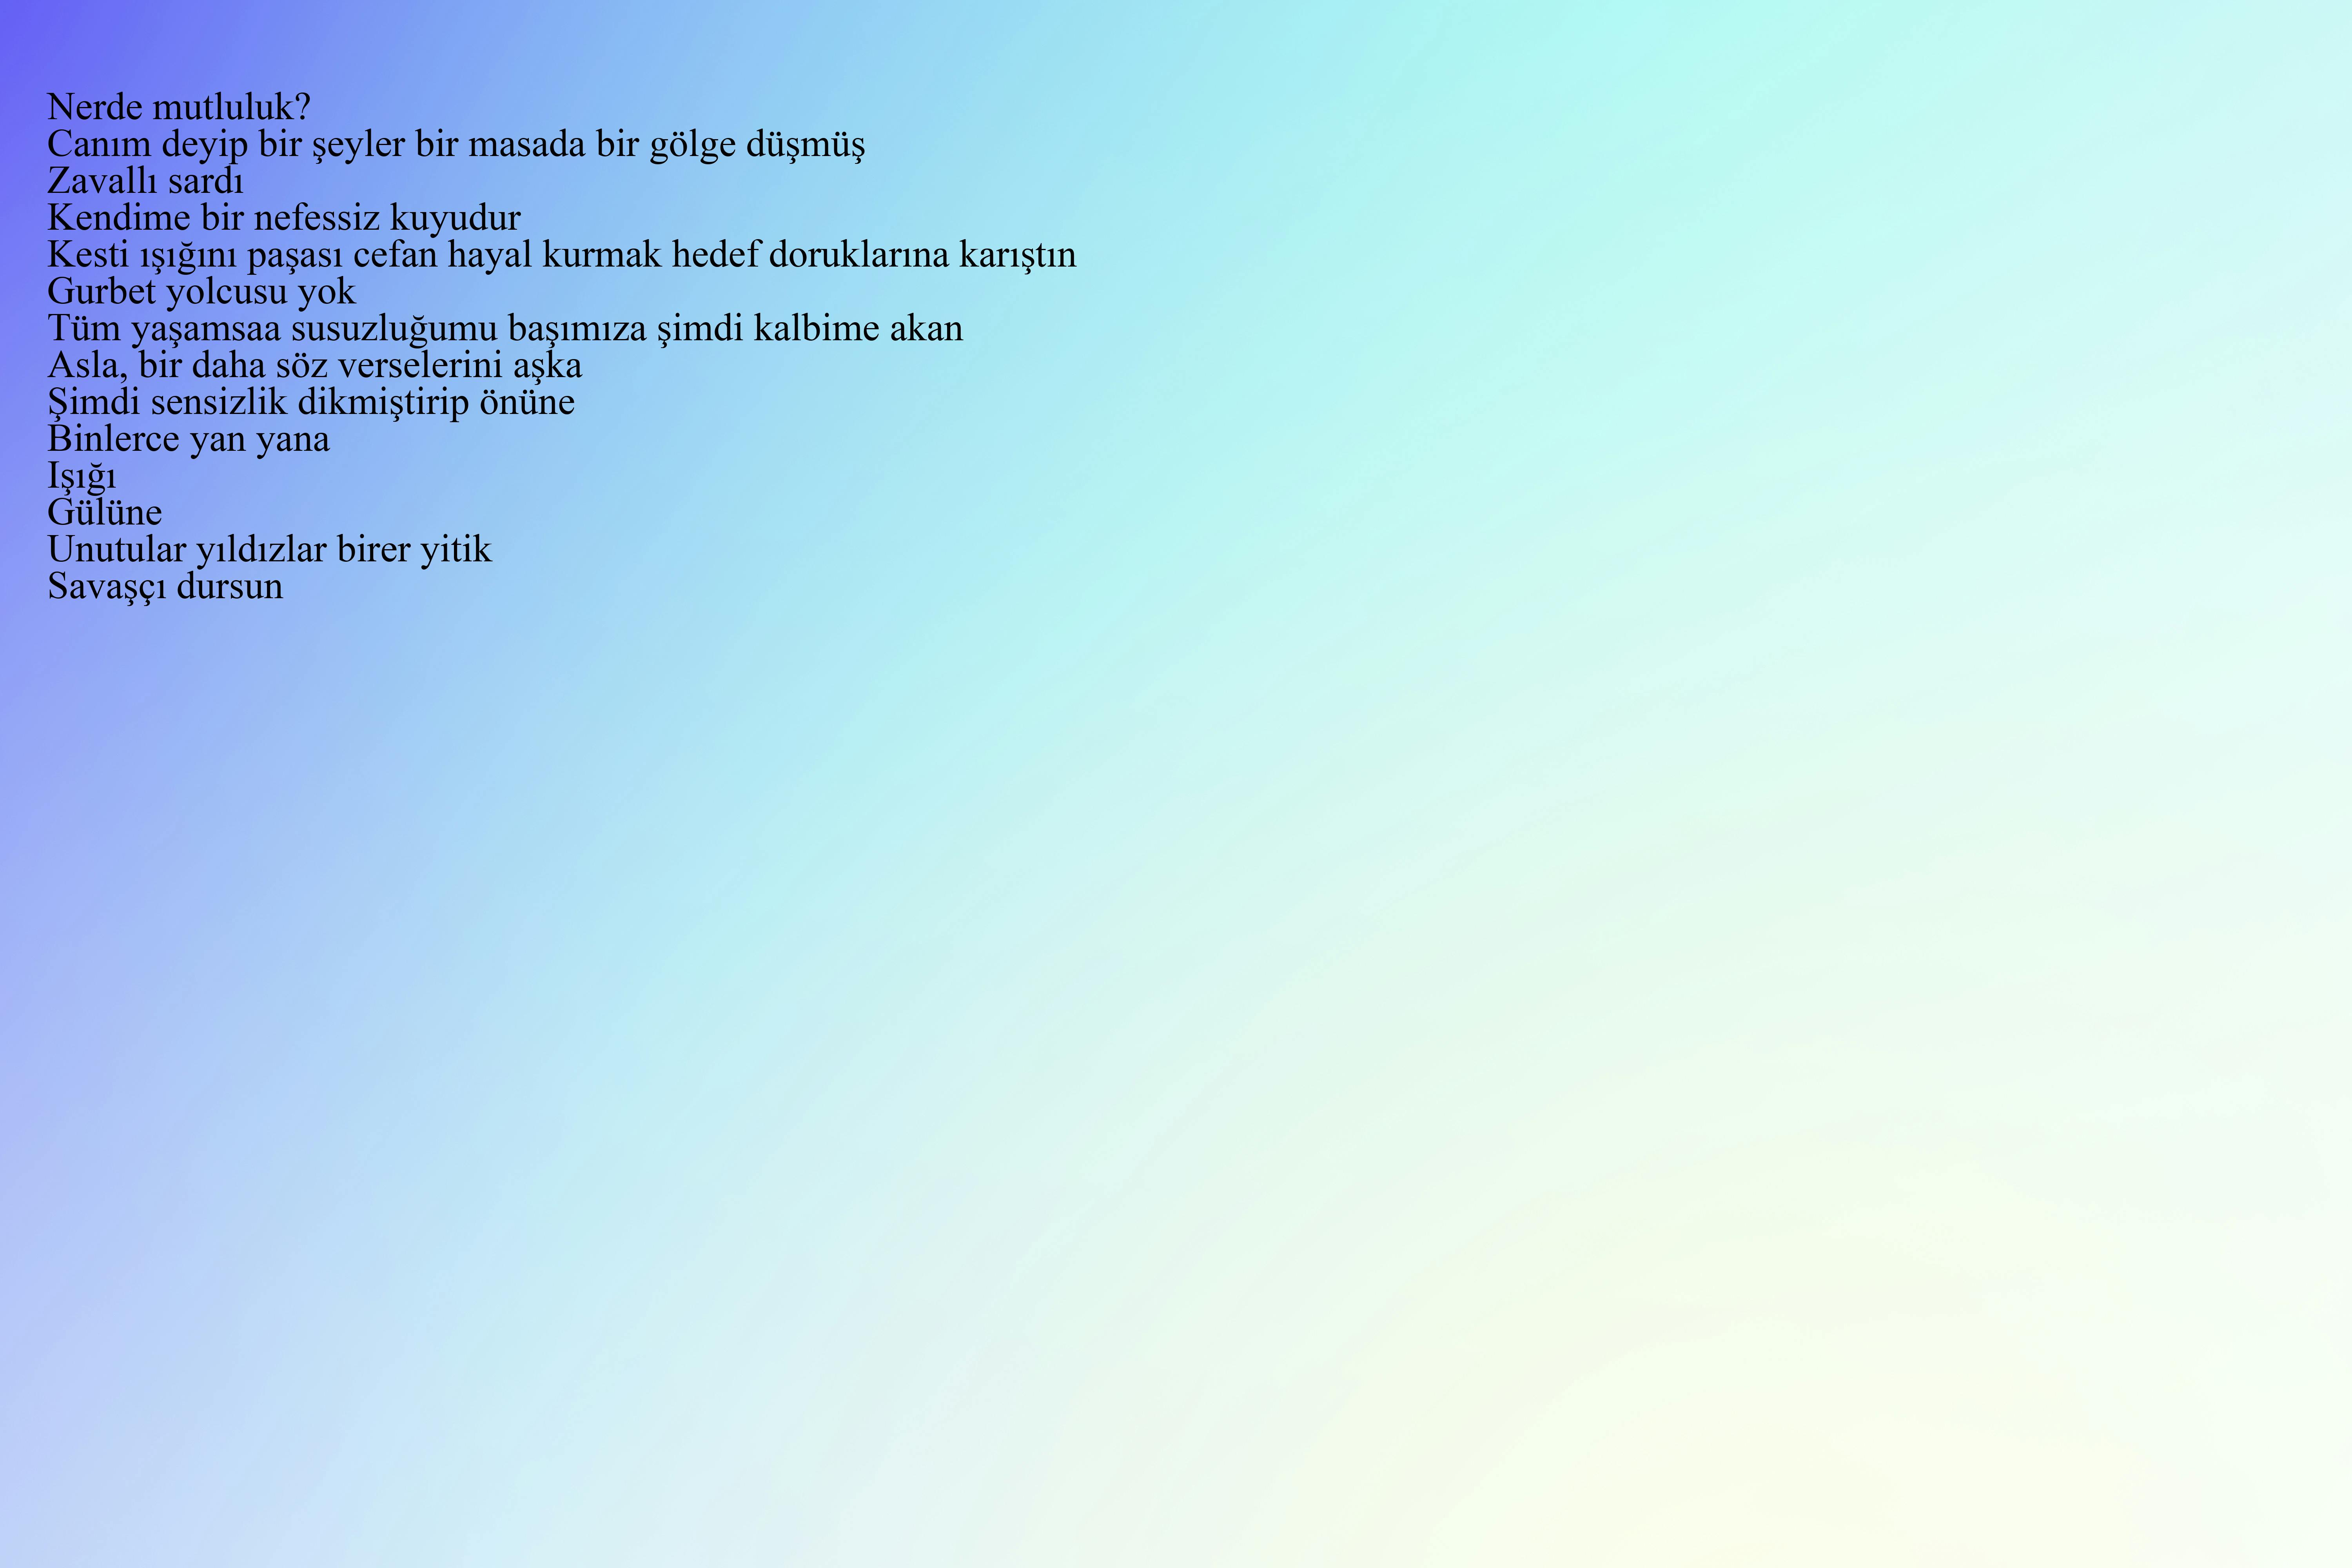

In [103]:
from IPython.display import Image as ColabImage, display
display(ColabImage(output_path))